In [1]:
!pip install mne

In [2]:
import numpy as np
import os.path as op
import matplotlib.pyplot as plt
import requests
import pandas as pd
from pandas import read_csv
from datetime import datetime, timedelta
from pandas import read_json
import traceback
import math
from math import fabs, log 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.manifold import MDS
from sklearn.metrics import mean_squared_error
import mne
from mne.io import read_raw_fif, concatenate_raws
from mne.datasets import visual_92_categories
from sklearn.svm import SVC
import pickle


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

path = "gdrive/Team Drives/DataForMNE/mne_data/MNE-visual_92_categories-data"
data_path = path
fname = op.join(path, 'visual_stimuli.csv')
conds = read_csv(fname)
print(conds.head(5))

max_trigger = 92
conds = conds[:max_trigger] 

ModuleNotFoundError: No module named 'google.colab'

In [4]:
conditions = []
for c in conds.values:
    cond_tags = list(c[:2])
    cond_tags += [('not-' if i == 0 else '') + conds.columns[k]
                  for k, i in enumerate(c[2:], 2)]
    conditions.append('/'.join(map(str, cond_tags)))
print(conditions[:10])


['0/human bodypart/human/not-face/animal/natural', '1/human bodypart/human/not-face/animal/natural', '2/human bodypart/human/not-face/animal/natural', '3/human bodypart/human/not-face/animal/natural', '4/human bodypart/human/not-face/animal/natural', '5/human bodypart/human/not-face/animal/natural', '6/human bodypart/human/not-face/animal/natural', '7/human bodypart/human/not-face/animal/natural', '8/human bodypart/human/not-face/animal/natural', '9/human bodypart/human/not-face/animal/natural']


In [5]:
event_id = dict(zip(conditions, conds.trigger + 1))
event_id['0/human bodypart/human/not-face/animal/natural']

1

In [6]:
n_runs = 4  # 4 for full data (use less to speed up computations)
fname = op.join(data_path, 'sample_subject_%i_tsss_mc.fif')
raws = [read_raw_fif(fname % block, verbose='error')
        for block in range(n_runs)]  # ignore filename warnings
raw = concatenate_raws(raws)

events = mne.find_events(raw, min_duration=.002)

events = events[events[:, 2] <= max_trigger]

4142 events found
Event IDs: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93 200 222 244]


In [8]:
picks = mne.pick_types(raw.info, meg=True)
epochs = mne.Epochs(raw, events=events, event_id=event_id, baseline=None,
                    picks=picks, tmin=-.1, tmax=.500, preload=True)

2760 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Loading data for 2760 events and 601 original time points ...
2 bad epochs dropped


In [0]:
epochs['face'].average().plot()
epochs['not-face'].average().plot()

In [0]:
X = epochs.copy().crop(0.095, 0.15).get_data().mean(axis=2)
y = epochs.events[:, 2]


In [0]:
# Classify using the average signal in the window 50ms to 300ms
# to focus the classifier on the time interval with best SNR.

from sklearn.model_selection import GridSearchCV

scaler = StandardScaler()
scaler = scaler.fit(X)
X = scaler.transform(X)
clf = GridSearchCV(SVC(probability=True, gamma="auto"),
                       param_grid={'kernel':['linear', 'rbf', 'poly'], 'C':[1, 10],
                                   'probability': [True], 'degree': [5, 50, 500]},
                       cv=10,
                       n_jobs = -1,
                       refit=True)

clf.fit(X, y)
y_pred = clf.predict_proba(X)

In [0]:
# Save Model
path = "" #"gdrive/Team Drives/DataForMNE/Saved Models/"
name = "clf_save_test"
filename = path + name
pickle.dump(clf, open(name, "wb"))

In [0]:
# Load Model
loaded_model = pickle.load(open(name, "rb"))
y_predTest = loaded_model.predict_proba(X)

In [0]:
np.array_equal(y_pred, y_predTest)

In [0]:
confusion = np.zeros((len(classes), len(classes)))
for ii, train_class in enumerate(classes):
    for jj in range(ii, len(classes)):
        confusion[ii, jj] = roc_auc_score(y == train_class, y_pred[:, jj])
        confusion[jj, ii] = confusion[ii, jj]

In [0]:
labels = ['']*5+['human bodypart']+['']*12+['human face']+['']*12+['nonhuman bodypart']+['']*12+['nonhuman face']+['']*17+['natural inanimate']+['']*16+['artificial inanimate']+['']*6

fig, ax = plt.subplots(1)
im = ax.matshow(confusion, cmap='RdBu_r', clim=[0.3, 0.7])
ax.set_yticks(range(len(classes)))
ax.set_yticklabels(labels)
ax.set_xticks(range(len(classes)))
ax.set_xticklabels(labels, rotation=40, ha='left')
ax.axhline(12, color='k') ## human bodypart
ax.axhline(24, color='k') ## human face
ax.axhline(36, color='k') ## nonhuman bodypart
ax.axhline(48, color='k') ## nonhuman face
ax.axhline(70, color='k') ## natural inanimate
ax.axvline(12, color='k') ## human bodypart
ax.axvline(24, color='k') ## human face
ax.axvline(36, color='k') ## nonhuman bodypart
ax.axvline(48, color='k') ## nonhuman face
ax.axvline(70, color='k') ## natural inanimate
plt.colorbar(im)
plt.tight_layout()
plt.show()

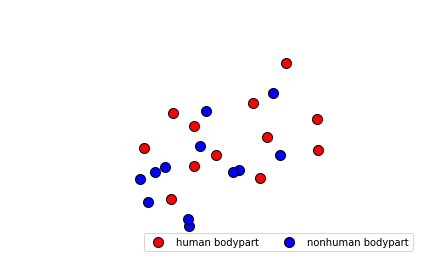

In [0]:
fig, ax = plt.subplots(1)
mds = MDS(2, random_state=0, dissimilarity='precomputed')
chance = 0.5
summary = mds.fit_transform(chance - confusion)
cmap = plt.get_cmap('rainbow')
colors = ['r', 'b']
names = list(conds['condition'].values)
for color, name in zip(colors, set(names)):
    sel = np.where([this_name == name for this_name in names])[0]
    size = 500 if name == 'human face' else 100
    ax.scatter(summary[sel, 0], summary[sel, 1], s=size,
               facecolors=color, label=name, edgecolors='k')
ax.axis('off')
ax.legend(loc='lower right', scatterpoints=1, ncol=2)
plt.tight_layout()
plt.show()

In [0]:
#esemble Methods 

In [16]:

X = epochs.copy().crop(0.095, 0.15).get_data()
y = epochs.events[:, 2]

## Shuffle the lists


indices = np.arange(X.shape[0])
np.random.shuffle(indices)

X = X[indices]
y = y[indices]
print(X.shape)
print(y.shape)

(2758, 306, 56)
(2758,)


In [0]:
numCats = 92
numTrials = X.shape[0]

oneHotY = np.zeros((numTrials, numCats))
for i in range(numTrials):
    oneHotY[i][y[i]-1] = 1
